In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import requests
import datetime

In [3]:
pip install alpha_vantage

In [4]:
#pull out data
API_KEY = 'L8XPSAPT0XAM5B6G'

symbol = 'SPY'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full'

response = requests.get(url)
data = response.json()

# Check if the data retrieval was successful
if 'Time Series (Daily)' in data:
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df = df[['1. open', '2. high', '3. low', '4. close', '5. volume']]
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    print(df.head())
else:
    print("Error retrieving data")

                Open      High       Low     Close   Volume
1999-11-01  136.5000  137.0000  135.5625  135.5625  4006500
1999-11-02  135.9687  137.2500  134.5937  134.5937  6516900
1999-11-03  136.0000  136.3750  135.1250  135.5000  7222300
1999-11-04  136.7500  137.3593  135.7656  136.5312  7907500
1999-11-05  138.6250  139.1093  136.7812  137.8750  7431500


In [5]:
#plot data
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick Chart')])

fig.update_layout(title="SPY Stock Price",
                  xaxis_title="Date",
                  yaxis_title="Price",
                  template="plotly_dark")

fig.show()

In [7]:
#clean and add features
#added the necessary features like moving averages and the Relative Strength Index (RSI)
# Convert columns to numeric values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Add Moving Averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Add RSI (14-day)
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI'] = compute_RSI(df['Close'])

# Drop rows with NaN values from moving averages and RSI
df = df.dropna()

print(df.head())

              Open    High     Low   Close    Volume      MA50       MA200  \
2001-05-31  125.43  126.76  125.26  125.95   9874200  122.1476  133.074952   
2001-06-01  126.20  127.10  125.12  126.73   8848300  122.4370  132.962821   
2001-06-04  126.80  127.43  126.08  127.34   5623500  122.7614  132.856396   
2001-06-05  127.49  129.23  127.27  128.80   9115400  123.0478  132.749459   
2001-06-06  128.83  128.83  127.36  127.73  12064900  123.2836  132.639671   

                  RSI  
2001-05-31  49.768672  
2001-06-01  55.252660  
2001-06-04  56.298701  
2001-06-05  58.660934  
2001-06-06  45.757997  


In [9]:
#prepare data for LSTM model
# Ensure the necessary libraries are imported
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scaling the data to the range (0, 1) for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'MA50', 'MA200', 'RSI']].values)

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])  # Create sequences from past 'seq_length' days
        y.append(data[i, 0])  # Predicting the 'Close' price (index 0)
    return np.array(x), np.array(y)

# Split data into training and test sets (80% for training, 20% for testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the sequence length (number of previous days to consider for prediction)
seq_length = 60  # 60 days of history to predict the next day

# Prepare training and test sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Check the shape of the prepared data
print(X_train.shape, X_test.shape)

(4739, 60, 5) (1140, 60, 5)


The model will have two LSTM layers and a dense layer for output

In [10]:
#build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Output the predicted closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0022
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 5.6803e-04
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 3.8369e-04
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 3.8304e-04
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 3.2073e-04
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.5887e-04
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 2.3405e-04
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 2.2315e-04
Epoch 9/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 2.5550e-04
Epoch 10/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 1.8496e-04


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


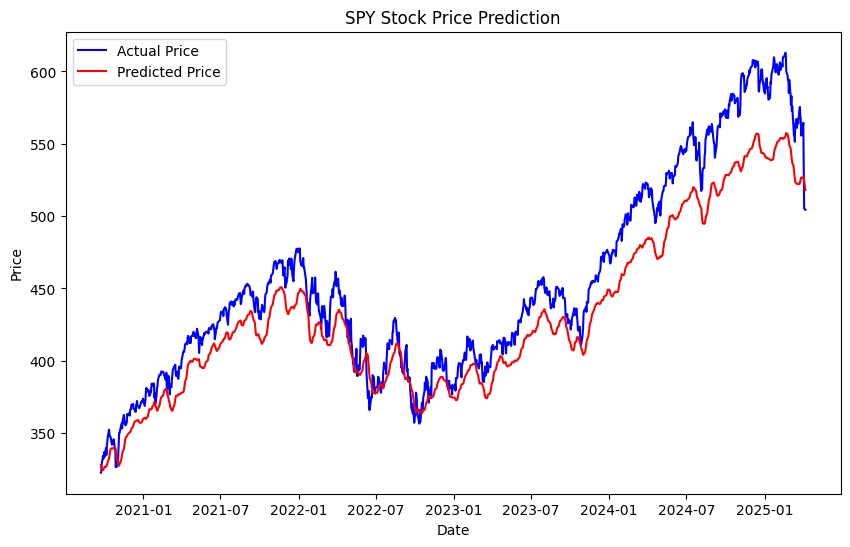

In [11]:
#make predictions
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:, 0]

# Get the actual values from the test set
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]

# Plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(df.index[train_size + seq_length:], y_test_actual, color='blue', label='Actual Price')
plt.plot(df.index[train_size + seq_length:], predictions, color='red', label='Predicted Price')
plt.title('SPY Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:
import plotly.graph_objs as go

# Create the figure
fig = go.Figure()

# Actual prices
fig.add_trace(go.Scatter(x=actual_dates, y=y_test_actual, mode='lines', name='Actual Price'))

# Predicted prices
fig.add_trace(go.Scatter(x=actual_dates, y=predictions, mode='lines', name='Predicted Price'))

# Add title and labels
fig.update_layout(
    title='SPY Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark'
)

fig.show()

In [12]:
#evaluate the model
#calculating the evaluation metrics (such as RMSE) to assess the performance of your model.
from sklearn.metrics import mean_squared_error
import math

# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 26.67516077178813


In [17]:
# Compile the model with accuracy as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 1.9335e-04 - loss: 0.3084
Training Loss: 0.41718098521232605
Training Accuracy: 0.00021101497986819595
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 7.1547e-05 - loss: 0.6443
Testing Loss: 0.5687829256057739
Testing Accuracy: 0.0008771930006332695


In [22]:
#Confusion Matrix and Classification Report
# Ensure y_test is binary (1 for higher, 0 for lower)
y_test_binary = y_test.astype(int)

# Convert continuous probabilities to binary predictions (1 if higher, 0 if lower)
predictions_binary = (predictions > 0.5).astype(int)  # 1 if probability > 0.5, else 0

# Now compute the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Get the confusion matrix
cm = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")
print(cm)

# Get the classification report (precision, recall, f1-score)
report = classification_report(y_test_binary, predictions_binary)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[   0 1139]
 [   0    1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1139
           1       0.00      1.00      0.00         1

    accuracy                           0.00      1140
   macro avg       0.00      0.50      0.00      1140
weighted avg       0.00      0.00      0.00      1140



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 8.6235e-05 - loss: 0.4181 - val_accuracy: 8.7719e-04 - val_loss: 0.5714
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 1.3299e-04 - loss: 0.4136 - val_accuracy: 8.7719e-04 - val_loss: 0.5646
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 2.6345e-04 - loss: 0.4150 - val_accuracy: 8.7719e-04 - val_loss: 0.5699
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 3.1302e-04 - loss: 0.4169 - val_accuracy: 8.7719e-04 - val_loss: 0.5721
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 2.8404e-04 - loss: 0.4212 - val_accuracy: 8.7719e-04 - val_loss: 0.5661
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 4.8078e-05 - loss: 0.4175 - val_accuracy: 8.7719e-04 - val_loss: 0.5635
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 4.2574e-04 - loss: 0.4161 - val_accuracy: 8.7719e-04 - val_loss: 0.5676
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━

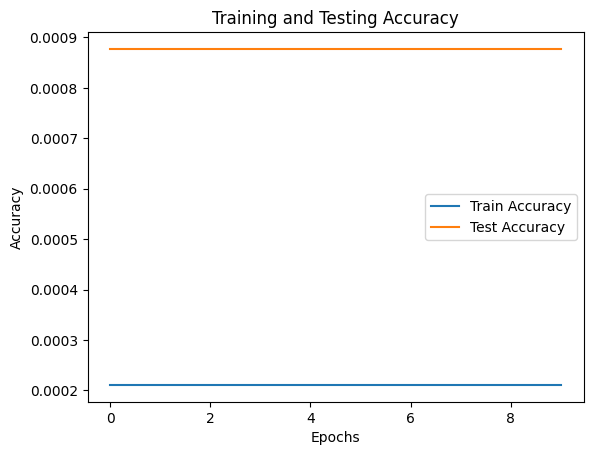

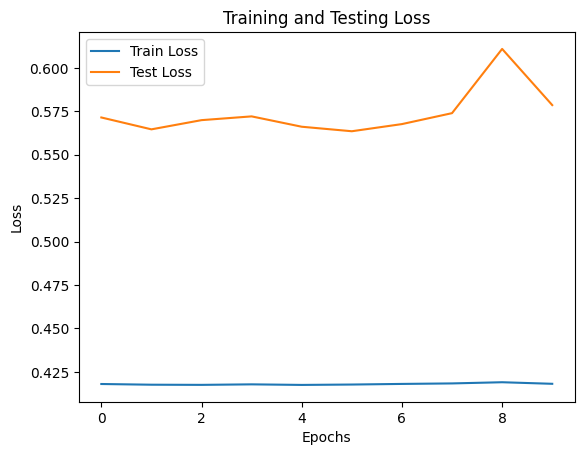

In [21]:
# Plot training and validation accuracy/loss curves
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Build the LSTM model
model = Sequential()

# Define the input layer (use the shape of the training data)
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Output the predicted closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.0055
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 6.3215e-04
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 4.8332e-04
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 3.9966e-04
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 4.4726e-04
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 3.5190e-04
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 2.4844e-04
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 2.6112e-04
Epoch 9/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 2.8561e-04
Epoch 10/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 2.5409e-04


In [25]:
#hyperparameter tuning
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
#adding more features
#changing LSTM structure so Bidirectional LSTMs for capturing patterns in both directions of time
df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
df['BB_up'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['BB_down'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

In [27]:
#updated model evaluation
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_actual, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 22.77649665008516


In [30]:
# Save the model ]
model.save('spy_stock_model.keras')

In [34]:
from tensorflow.keras.models import load_model

# Load the model without the optimizer's state
model = load_model('spy_stock_model.keras', compile=False)

# Compile the model again with the same optimizer settings
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
#rebuilding optimizer
from tensorflow.keras.optimizers import Adam

# Load the model without the optimizer's state
model = load_model('spy_stock_model.keras', compile=False)

# Compile with your desired optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [36]:
#using same parameters and extracting optimizer
from tensorflow.keras.optimizers import RMSprop

# Load the model with compile=False to avoid the optimizer state issue
model = load_model('spy_stock_model.keras', compile=False)

# Recompile with the same optimizer used when training the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')

In [37]:
#makinging predictions with loaded model
# Example: Predict the next day's price using the last 60 days of data from the test set
# Get the last 60 days' data (for real-time prediction, this would come from a live data source)
input_data = test_data[-60:].reshape((1, 60, 5))  # Reshape to fit the model's input shape

# Make prediction
prediction = model.predict(input_data)

# Inverse transform to get the actual predicted closing price
predicted_price = scaler.inverse_transform(np.concatenate((prediction, np.zeros((prediction.shape[0], 4))), axis=1))[:, 0]

print(f"Predicted closing price for the next day: {predicted_price[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted closing price for the next day: 14.079997986853131


In [38]:
#evaluating model perfomance
# Calculate RMSE (Root Mean Squared Error) on the test set
from sklearn.metrics import mean_squared_error
import math

# Inverse transform the actual values in the test set
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# You can also calculate other metrics like MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_actual, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 26.67516077178813
Mean Absolute Error (MAE): 22.77649665008516
